# MLB Player Analysis

## Goal:
How can we compare players of the past to players of today? Who is Hank Aaron most like today in terms of offensive statistics? Who are the players who are the cream of the crop?

## Approach
Since there is truly no right or wrong answer on determining a player's value, I decided to use a K means clustering algorithm to break out players in each year into different groups. Once the players are broken out, we can examine which group MVP candidates of that year fall into. I will run the analysis on all years prior to 2015 and then predict on the 2015 season to see which players are considered "valuable" by the clustering standards.

From there, we can look to see which values have the highest correlation for being in the "valuable" cluster. Is batting average a high indicator? What about more advanded metris like OPS? BABIP? Or do traditional statistics like HR, H, R, and RBI give the best indication if a player is valuable?

## Import Libraries

In [69]:
# Standard data science libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Statistics Libraries
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# Machine learning libraries
from sklearn.cluster import KMeans

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load in the data
This process does a for loop for all files that are in the current directory that end in a CSV (since those are the files that we are interested in loading). From there, I create global varables that have the same naming convention as the file

In [70]:
# For loop for each file in the directory
for file in os.listdir():
    # Does the file end in csv?
    if file.endswith('csv'):
        # Get the file name and create a new global variable
        file_name = file.replace('.csv','')
        globals()['{}'.format(file_name)] = pd.read_csv(file)
        print(file_name, 'loaded successfully')

Salaries loaded successfully
Schools loaded successfully
People loaded successfully
Batting loaded successfully
CollegePlaying loaded successfully


In [71]:
Salaries.tail()

,yearID,teamID,lgID,playerID,salary
26423,2016,WAS,NL,strasst01,10400000
26424,2016,WAS,NL,taylomi02,524000
26425,2016,WAS,NL,treinbl01,524900
26426,2016,WAS,NL,werthja01,21733615
26427,2016,WAS,NL,zimmery01,14000000


In [72]:
Schools.head()

,schoolID,name_full,city,state,country
0,abilchrist,Abilene Christian University,Abilene,TX,USA
1,adelphi,Adelphi University,Garden City,NY,USA
2,adrianmi,Adrian College,Adrian,MI,USA
3,akron,University of Akron,Akron,OH,USA
4,alabama,University of Alabama,Tuscaloosa,AL,USA


In [73]:
People.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,NaN,NaN,NaN,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,NaN,NaN,Don,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [74]:
Batting.tail()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
105856,zimmebr01,2018,1,CLE,AL,34,106,14,24,5,0,2,9.0,4.0,1.0,7,44.0,0.0,1.0,0.0,0.0,1.0
105857,zimmejo02,2018,1,DET,AL,25,2,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
105858,zimmery01,2018,1,WAS,NL,85,288,33,76,21,2,13,51.0,1.0,1.0,30,55.0,1.0,3.0,0.0,2.0,10.0
105859,zobribe01,2018,1,CHN,NL,139,455,67,139,28,3,9,58.0,3.0,4.0,55,60.0,1.0,2.0,1.0,7.0,8.0
105860,zuninmi01,2018,1,SEA,AL,113,373,37,75,18,0,20,44.0,0.0,0.0,24,150.0,0.0,6.0,0.0,2.0,7.0


In [75]:
CollegePlaying.head()

,playerID,schoolID,yearID
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
2,aardsda01,rice,2003
3,abadan01,gamiddl,1992
4,abadan01,gamiddl,1993


# Looking at an example

Since I was raised in Denver, the Colorado Rockies have been my favorite team to watch. Lets look at an example of one of Colorado's best players, Nolan Arenado. The data provided in the Batting table are all offensive statistics, but there are no "metrics" available like Batting Averag, On Base Percentage, Slugging Percentage, OPS, etc. 

In [76]:
Batting[Batting['playerID'] == 'arenano01']

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
97053,arenano01,2013,1,COL,NL,133,486,49,130,29,4,10,52.0,2.0,0.0,23,72.0,1.0,1.0,2.0,2.0,16.0
98471,arenano01,2014,1,COL,NL,111,432,58,124,34,2,18,61.0,2.0,1.0,25,58.0,1.0,4.0,1.0,5.0,13.0
99908,arenano01,2015,1,COL,NL,157,616,97,177,43,4,42,130.0,2.0,5.0,34,110.0,13.0,4.0,0.0,11.0,17.0
101400,arenano01,2016,1,COL,NL,160,618,116,182,35,6,41,133.0,2.0,3.0,68,103.0,10.0,2.0,0.0,8.0,17.0
102889,arenano01,2017,1,COL,NL,159,606,100,187,43,7,37,130.0,3.0,2.0,62,106.0,9.0,4.0,1.0,6.0,21.0
104382,arenano01,2018,1,COL,NL,156,590,104,175,38,2,38,110.0,2.0,2.0,73,122.0,10.0,3.0,1.0,6.0,16.0


# Some Data Cleanup

After doing some digging around, the stint category is one of the main identifier fields for a record in the table. For example, someone could be traded during the year, giving him 2 stints for the season. We want to look at the aggregate statistics for a season, not aggregate depending on which stint he was at during the year. So we are going to sum all of the fields together so everyone has 1 row per season

In [77]:
# Example before grouping data together
Batting[Batting['playerID'] == 'schoojo01']

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
98204,schoojo01,2013,1,BAL,AL,5,14,5,4,0,0,1,1.0,0.0,0.0,1,2.0,0.0,0.0,0.0,0.0,2.0
99621,schoojo01,2014,1,BAL,AL,137,455,48,95,18,0,16,45.0,2.0,0.0,13,122.0,0.0,8.0,5.0,0.0,12.0
101101,schoojo01,2015,1,BAL,AL,86,305,34,85,17,0,15,39.0,2.0,0.0,9,79.0,0.0,4.0,1.0,2.0,9.0
102580,schoojo01,2016,1,BAL,AL,162,615,82,164,38,1,25,82.0,1.0,2.0,21,137.0,0.0,8.0,0.0,3.0,16.0
104053,schoojo01,2017,1,BAL,AL,160,622,92,182,35,0,32,105.0,1.0,0.0,35,142.0,0.0,11.0,0.0,7.0,20.0
105564,schoojo01,2018,1,BAL,AL,85,349,45,85,18,1,17,40.0,0.0,1.0,12,74.0,1.0,3.0,1.0,2.0,8.0
105565,schoojo01,2018,2,MIL,NL,46,124,16,25,4,0,4,21.0,1.0,0.0,7,41.0,1.0,1.0,0.0,2.0,3.0


In [78]:
Batting_Grouped = Batting.groupby(['playerID','yearID'], as_index = False).sum()

In [79]:
# Example after grouping data together
Batting_Grouped[Batting_Grouped['playerID'] == 'schoojo01']

,playerID,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
79122,schoojo01,2013,1,5,14,5,4,0,0,1,1.0,0.0,0.0,1,2.0,0.0,0.0,0.0,0.0,2.0
79123,schoojo01,2014,1,137,455,48,95,18,0,16,45.0,2.0,0.0,13,122.0,0.0,8.0,5.0,0.0,12.0
79124,schoojo01,2015,1,86,305,34,85,17,0,15,39.0,2.0,0.0,9,79.0,0.0,4.0,1.0,2.0,9.0
79125,schoojo01,2016,1,162,615,82,164,38,1,25,82.0,1.0,2.0,21,137.0,0.0,8.0,0.0,3.0,16.0
79126,schoojo01,2017,1,160,622,92,182,35,0,32,105.0,1.0,0.0,35,142.0,0.0,11.0,0.0,7.0,20.0
79127,schoojo01,2018,3,131,473,61,110,22,1,21,61.0,1.0,1.0,19,115.0,2.0,4.0,1.0,4.0,11.0


# New Metrics

To give the data a little more depth, I am going to add in some more metrics that help evaluate the effectiveness of an offensive player.

1. Batting Average (BA) - The percentage of time that they get a hit
2. Total Basees (TB) - A weighted calculation to favor people who hit more extra base hits. Singles * 1 + Doubles * 2 + Triples * 3 + Home Runs * 4
3. Slugging Percentage (SLG) - The total bases divided by the number of at bats
4. On Base Percentage (OBP) - The percentage of time that they get on base
5. On Base + Slugging (OPS) - This is a highly regarded statistic in baseball. It gives a way to measure the effectiveness by putting power and on base percentage on a more level playing field. This way, a big power hitter can be compared to a smaller player who puts the ball in play more often.
6. Batting Average On Balls In Play (BABIP) - Percentage of time that a player gets a hit when they put the ball in play. This is a different way to gague how well they hit the ball by taking out strikeouts
7. RBI/AB. The number of RBI's a player receives per at bat
8. HR/G. The number of home runs a player averages each game
9. R/G. The number of runs a player averages each game

In [80]:
def total_bases(row):
    """ Creates the total bases calculation"""
    doubles = row['2B']
    triples = row['3B']
    home_runs = row['HR']
    
    singles = row['H'] - doubles - triples - home_runs
    
    return singles + doubles*2 + triples*3 + home_runs*4

In [81]:
def batting_avg_ball_in_play(row):
    """
    Calculates the batting average of balls in play
    
    BABIP = (H – HR)/(AB – K – HR + SF)
    
    """
    H = row['H']
    HR = row['HR']
    AB = row['AB']
    K = row['SO']
    SF = row['SH']
    
    return 0 if (AB - K - HR + SF) < 1 else (H - HR)/(AB - K - HR + SF)

In [82]:
Batting_Grouped['BA'] = Batting_Grouped['H'] / Batting_Grouped['AB']
Batting_Grouped['TOTB'] = Batting_Grouped.apply(total_bases, axis = 1)
Batting_Grouped['SLG'] = Batting_Grouped['TOTB'] / Batting_Grouped['AB']
Batting_Grouped['OBP'] = (Batting_Grouped['H'] + Batting_Grouped['BB'] + Batting_Grouped['HBP']
                          + Batting_Grouped['IBB']) / Batting_Grouped['AB']
Batting_Grouped['OPS'] = Batting_Grouped['SLG'] + Batting_Grouped['OBP']
Batting_Grouped['BABIP'] = Batting_Grouped.apply(batting_avg_ball_in_play, axis = 1)
Batting_Grouped['RBI/AB'] = Batting_Grouped['RBI'] / Batting_Grouped['AB']
Batting_Grouped['HR/G'] = Batting_Grouped['HR'] / Batting_Grouped['G']
Batting_Grouped['R/G'] = Batting_Grouped['R'] / Batting_Grouped['G']

In [83]:
Batting_Grouped[Batting_Grouped['playerID'] == 'arenano01']

,playerID,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,BA,TOTB,SLG,OBP,OPS,BABIP,RBI/AB,HR/G,R/G
2283,arenano01,2013,1,133,486,49,130,29,4,10,52.0,2.0,0.0,23,72.0,1.0,1.0,2.0,2.0,16.0,0.267490,197,0.405350,0.318930,0.724280,0.295567,0.106996,0.075188,0.368421
2284,arenano01,2014,1,111,432,58,124,34,2,18,61.0,2.0,1.0,25,58.0,1.0,4.0,1.0,5.0,13.0,0.287037,216,0.500000,0.356481,0.856481,0.296919,0.141204,0.162162,0.522523
2285,arenano01,2015,1,157,616,97,177,43,4,42,130.0,2.0,5.0,34,110.0,13.0,4.0,0.0,11.0,17.0,0.287338,354,0.574675,0.370130,0.944805,0.290948,0.211039,0.267516,0.617834
2286,arenano01,2016,1,160,618,116,182,35,6,41,133.0,2.0,3.0,68,103.0,10.0,2.0,0.0,8.0,17.0,0.294498,352,0.569579,0.423948,0.993528,0.297468,0.215210,0.256250,0.725000
2287,arenano01,2017,1,159,606,100,187,43,7,37,130.0,3.0,2.0,62,106.0,9.0,4.0,1.0,6.0,21.0,0.308581,355,0.585809,0.432343,1.018152,0.323276,0.214521,0.232704,0.628931
2288,arenano01,2018,1,156,590,104,175,38,2,38,110.0,2.0,2.0,73,122.0,10.0,3.0,1.0,6.0,16.0,0.296610,331,0.561017,0.442373,1.003390,0.317865,0.186441,0.243590,0.666667


# Final Data Cleanup

Now that we have all the metrics in, we should only be looking at the metrics and fields that are known to be important to determing whether a player is valuable or not. HBP, IBB, SH and other metrics are either not thought to be important for offensive effeciency, or are being measured in the new calculations that were added.

We are also going to fill any value that is NULL or Infinity as 0 since those happen when you are making calculations like 0/0

In [84]:
Cleaned_Batting = Batting_Grouped[['playerID', 'yearID','G', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'BB','BA',
       'TOTB', 'SLG', 'OBP', 'OPS', 'RBI/AB', 'HR/G', 'R/G', 'BABIP']].fillna(0).replace(np.inf, 0)

In [85]:
Cleaned_Batting.sample(10)

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP
75225,rockepa01,1976,4,5,0,1,0,0,0,0.0,0,0.200000,1,0.200000,0.200000,0.400000,0.000000,0.000000,0.000000,0.250000
73838,riceji01,1979,158,619,117,201,39,6,39,130.0,57,0.324717,369,0.596123,0.429725,1.025848,0.210016,0.246835,0.740506,0.335404
58124,mcnerje01,1967,56,123,8,28,6,0,3,13.0,6,0.227642,43,0.349593,0.317073,0.666667,0.105691,0.053571,0.142857,0.227273
89154,treshmi01,1946,80,217,28,47,5,2,0,21.0,36,0.216590,56,0.258065,0.396313,0.654378,0.096774,0.000000,0.350000,0.237374
1852,anderke01,1990,49,143,16,44,6,1,1,5.0,13,0.307692,55,0.384615,0.412587,0.797203,0.034965,0.020408,0.326531,0.338583
574,affelje01,2005,49,0,0,0,0,0,0,0.0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61687,morrijo01,1879,84,348,56,98,18,5,0,49.0,14,0.281609,126,0.362069,0.321839,0.683908,0.140805,0.000000,0.666667,0.310127
94334,whittpo01,1915,128,448,46,126,17,3,1,43.0,29,0.281250,152,0.339286,0.350446,0.689732,0.095982,0.007812,0.359375,0.292056
12789,camermi01,2003,147,534,74,135,31,5,18,76.0,70,0.252809,230,0.430712,0.395131,0.825843,0.142322,0.122449,0.503401,0.307895
74460,ritzke01,1992,23,0,0,0,0,0,0,0.0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Normalizing The Data

From here, this is where we can really start to come up with some valuations. For each year, we want to see what percentile any player finished in one of the categories. You would assume that players who finish in high percentiles would be considered valuable.

We go through each year, normalize the data by getting Z score (Z score is just a way to normalize the data, comparing data to the category's mean and varaince of the distribution), and then find the percentile of that Z score to make it easier to read. 

In [86]:
# Get the columns that we want to normalize
normalize_columns =[col for col in Cleaned_Batting.columns if col not in ['playerID','yearID']]

In [87]:
# Get all of the years we're interested in, in order
years = Cleaned_Batting.yearID.unique()[Cleaned_Batting.yearID.unique() < 2019]
years.sort()

In [88]:
# Create the Normalized Batting data frame
Normalized_Batting = Cleaned_Batting[Cleaned_Batting['playerID'] == 1].copy()

for year in years:
    # Create a data frame for a specific year and only consider players with more than 100
    # at bats so we don't dilute the data
    df = Cleaned_Batting[(Cleaned_Batting['yearID'] == year) & (Cleaned_Batting['AB'] > 100)]
    
    #For each column, normalize the data, convert it to a percentile, and then replace it
    for col in normalize_columns:
        scaler = StandardScaler()
        scaler.fit(df[[col]])
        df[col] = norm.cdf(scaler.transform(df[[col]]))
        
    Normalized_Batting = Normalized_Batting.append(df)

## New look
Now from the Normalized Batting data frame, we can see what percentile Nolan Arenado finished in that year for that given metric. For example, in 2015, Nolan finished in the 99th percentile in Slugging Percentage, Home Runs, and RBI's, which would indicate that he is a very powerful hitter

In [89]:
Normalized_Batting[Normalized_Batting['playerID'] == 'arenano01']

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP
2283,arenano01,2013,0.772397,0.802843,0.585178,0.795578,0.856003,0.877934,0.489747,0.653572,0.341636,0.674912,0.757294,0.567961,0.255538,0.419742,0.424184,0.395229,0.431920,0.486679
2284,arenano01,2014,0.547418,0.689612,0.726811,0.756691,0.938823,0.522474,0.858207,0.783967,0.388274,0.849653,0.837384,0.951192,0.538472,0.863740,0.804074,0.918313,0.857996,0.480793
2285,arenano01,2015,0.907542,0.946265,0.977674,0.960878,0.993262,0.792687,0.999621,0.999544,0.552365,0.837220,0.995409,0.989129,0.603575,0.942947,0.994354,0.996297,0.944242,0.410093
2286,arenano01,2016,0.917976,0.943349,0.992873,0.963364,0.943524,0.971445,0.996940,0.998669,0.946259,0.884667,0.989605,0.983875,0.878797,0.973843,0.993741,0.985901,0.985566,0.474189
2287,arenano01,2017,0.921335,0.942151,0.967083,0.976784,0.989822,0.996181,0.986507,0.998198,0.885279,0.941303,0.991399,0.982273,0.870130,0.970007,0.983108,0.942426,0.910694,0.712265
2288,arenano01,2018,0.906154,0.934356,0.983563,0.968954,0.968640,0.526137,0.996489,0.992915,0.956828,0.922374,0.988375,0.980437,0.926776,0.976827,0.954660,0.982615,0.966875,0.689224


# But does that mean Nolan Arenado is a valuable hitter in 2015?

Nolan is in the upper percentiles for most the offensive categories, but are those the right categories to be considered a valuable hitter? What do other hitters finish at the top of who are considered for awards? This is where the clustering algorithm will come in. 

However, we don't want the clustering algorithm to break each cluster into equal parts. We want the truly valuable players all brought together and separated from the rest of the pack, which should be a smaller percentage compared to the rest of the population.

First, we should see how many clusters we should start with. We will work with the data prior to 2015, and then test it out on the 2015 season to see if we agree with its predictions. We will use the elbow method (looking for the drop off to significantly stop in the visualization) to determine how many clusters to use

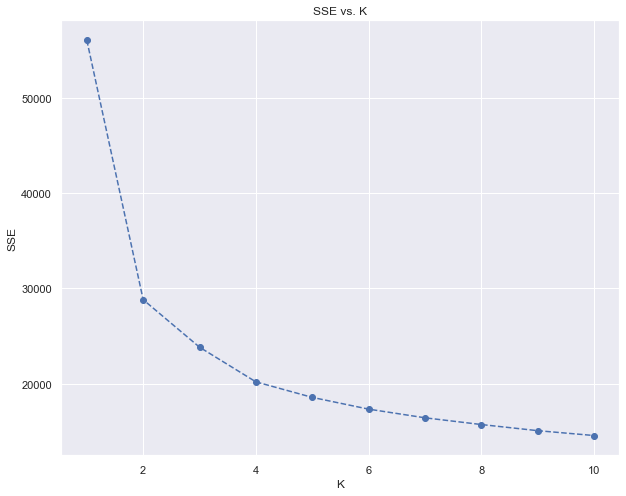

In [90]:
scores = []
cluster_data = Normalized_Batting[Normalized_Batting['yearID'] < 2015][normalize_columns]

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(cluster_data)
    
    scores.append(abs(model.score(cluster_data)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

There really isn't a true "elbow", but we can see that the drop off starts to slow down right around 3 clusters, so we will start with that. 3 clusters is also easy to interpret (bad, average, great)

In [91]:
kmeans = KMeans(3, random_state = 534)
normalized_model = kmeans.fit(Normalized_Batting[Normalized_Batting['yearID'] < 2015][normalize_columns])
Normalized_Batting['Cluster'] = kmeans.predict(Normalized_Batting[normalize_columns])

In [92]:
Normalized_Batting[Normalized_Batting['yearID'] == 2015].head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP,Cluster
214,abreujo02,2015,0.893012,0.944184,0.950965,0.962630,0.941345,0.649517,0.980287,0.986017,0.645348,0.858115,0.978271,0.906075,0.770543,0.882056,0.896178,0.938147,0.894465,0.806352,0
280,ackledu01,2015,0.487656,0.225228,0.240935,0.208401,0.227814,0.649517,0.452021,0.294393,0.261073,0.254296,0.272754,0.624293,0.207746,0.427178,0.577186,0.475624,0.148745,0.071072,1
423,adamsma01,2015,0.086919,0.125338,0.105030,0.138707,0.171787,0.181075,0.252825,0.220055,0.152473,0.344339,0.143884,0.352155,0.168276,0.243647,0.691448,0.418345,0.108933,0.370038,1
563,adriaeh01,2015,0.056884,0.062207,0.085144,0.063128,0.125445,0.315787,0.113006,0.101438,0.216305,0.023639,0.064060,0.029299,0.487597,0.112265,0.275835,0.065389,0.081919,0.022944,1
681,ahmedni01,2015,0.754571,0.651723,0.548493,0.512608,0.443195,0.953454,0.409213,0.349629,0.456399,0.206100,0.507819,0.264474,0.152462,0.188358,0.146474,0.323001,0.397287,0.132838,2


From the eyeball test, it looks like Cluster 0 has a player who finished high in some offensive categories, so let's take a look at the players in that cluster

In [93]:
Normalized_Batting[(Normalized_Batting['yearID'] == 2015) & (Normalized_Batting['Cluster'] ==0)].head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP,Cluster
214,abreujo02,2015,0.893012,0.944184,0.950965,0.962630,0.941345,0.649517,0.980287,0.986017,0.645348,0.858115,0.978271,0.906075,0.770543,0.882056,0.896178,0.938147,0.894465,0.806352,0
1469,altuvjo01,2015,0.893012,0.959705,0.942452,0.987649,0.984972,0.792687,0.664404,0.801746,0.533237,0.959704,0.966243,0.767945,0.744624,0.780851,0.334579,0.505657,0.876007,0.783807,0
1533,alvarpe01,2015,0.871173,0.687952,0.710237,0.603955,0.483113,0.181075,0.958424,0.898336,0.790127,0.372314,0.760338,0.806642,0.654692,0.769483,0.942353,0.904490,0.496696,0.335571,0
2285,arenano01,2015,0.907542,0.946265,0.977674,0.960878,0.993262,0.792687,0.999621,0.999544,0.552365,0.837220,0.995409,0.989129,0.603575,0.942947,0.994354,0.996297,0.944242,0.410093,0
4832,bautijo02,2015,0.887820,0.875558,0.992659,0.814951,0.856224,0.649517,0.999183,0.996524,0.999927,0.462206,0.964287,0.961640,0.977524,0.980771,0.993850,0.995100,0.987390,0.070654,0


# Normalized Data Results
Looking at the players in Cluster 2, we do get the top tier players including the MVP's Josh Donaldson and Bryce Harper. However, if we take a look at how many players are in each cluster, it is a little too evened out between the three. It says that Cluster 2 has 25% of the players from the 2015 season in that category. We want that cluster to only be the cream of the crop.

In [94]:
Normalized_Batting[(Normalized_Batting['yearID'] == 2015)]['Cluster'].value_counts(normalize = True)

1    0.402353
2    0.345882
0    0.251765
Name: Cluster, dtype: float64

# Approach # 2

What if we really identify which players are the cream of the crop? I decided to make one tweak to this dataframe, and that was to replace each column with indicator flags whether they were in the top 10th percentile for that season. That way, it will be a lot more black and white on which players are considered the best in the league

In [95]:
Top10Percentiles_Batting = Normalized_Batting.copy()

for col in normalize_columns:
    Top10Percentiles_Batting[col] = np.array(Top10Percentiles_Batting[col] > .9,int)
    
Top10Percentiles_Batting['Total'] = Top10Percentiles_Batting[normalize_columns].sum(axis = 1)

In [96]:
Top10Percentiles_Batting[Top10Percentiles_Batting['playerID'] == 'arenano01']

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP,Cluster,Total
2283,arenano01,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
2284,arenano01,2014,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3
2285,arenano01,2015,1,1,1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,13
2286,arenano01,2016,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,15
2287,arenano01,2017,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,0,15
2288,arenano01,2018,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,16


Now we can see that in 2015, Nolan was in the top 10 percentile for 13 of the 18 categories we are interested in.

# Lets try the clustering method again but on the percentiles data frame

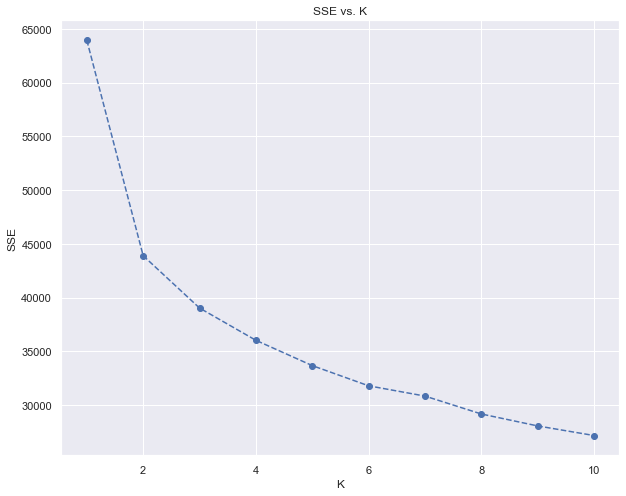

In [97]:
scores = []
cluster_data = Top10Percentiles_Batting[Top10Percentiles_Batting['yearID'] < 2015][normalize_columns]

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(cluster_data)
    
    scores.append(abs(model.score(cluster_data)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

Once again, we are seeing that 3 clusters is a good options with this problem

In [123]:
kmeans = KMeans(3, random_state = 534)
model = kmeans.fit(Top10Percentiles_Batting[Top10Percentiles_Batting['yearID'] < 2015][normalize_columns ])
Top10Percentiles_Batting['Cluster'] = model.predict(Top10Percentiles_Batting[normalize_columns ])
Top10Percentiles_Batting = pd.merge(Top10Percentiles_Batting, People)[['playerID','nameFirst','nameLast', 'yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'BA', 'TOTB', 'SLG', 'OBP', 'OPS', 'RBI/AB', 'HR/G', 'R/G',
       'BABIP', 'Cluster', 'Total']]

So in this example, it looks like Cluster 2 is the cluster that has the most top tier players, including Arenado!

In [124]:
Top10Percentiles_Batting[Top10Percentiles_Batting['yearID'] == 2015].sort_values('Total',ascending = False).head(10)

,playerID,nameFirst,nameLast,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP,Cluster,Total
40101,goldspa01,Paul,Goldschmidt,2015,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,2,17
40296,troutmi01,Mike,Trout,2015,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,2,16
39292,vottojo01,Joey,Votto,2015,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,2,15
40258,rizzoan01,Anthony,Rizzo,2015,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,2,15
40472,harpebr03,Bryce,Harper,2015,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,2,15
40407,donaljo02,Josh,Donaldson,2015,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,0,2,14
40375,cespeyo01,Yoenis,Cespedes,2015,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,0,2,13
40630,arenano01,Nolan,Arenado,2015,1,1,1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,2,13
40361,carpema01,Matt,Carpenter,2015,0,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,0,2,13
38103,cruzne01,Nelson,Cruz,2015,0,1,1,1,0,0,1,1,1,1,1,1,0,1,0,1,1,1,2,13


This is what we wanted! Only 7.5% of the player population in 2015 fits into cluster 2

In [218]:
Top10Percentiles_Batting[Top10Percentiles_Batting['yearID'] == 2015]['Cluster'].value_counts(normalize = True)

0    0.818594
1    0.102041
2    0.079365
Name: Cluster, dtype: float64

# So what makes Cluster 2 so special?
We have shown that our clustering algorithm does a great job separating out the best players from the rest of the pack, but taking a closer look shows that not all players have the same fields filled out. These are still very good players, but what makes them so similar to the other big time players who lead in almost every offensive category?

In [219]:
Top10Percentiles_Batting[(Top10Percentiles_Batting['yearID'] == 2015) & (Top10Percentiles_Batting['Cluster'] == 2)
                        ].sort_values('Total').head(10)

,playerID,nameFirst,nameLast,yearID,G,AB,R,H,2B,3B,HR,RBI,BB,BA,TOTB,SLG,OBP,OPS,RBI/AB,HR/G,R/G,BABIP,Cluster,Total
41315,sanomi01,Miguel,Sano,2015,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,2,6
40047,dudalu01,Lucas,Duda,2015,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0,2,6
39898,stantmi03,Giancarlo,Stanton,2015,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,2,6
38812,raburry01,Ryan,Raburn,2015,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,1,2,6
41058,peralda01,David,Peralta,2015,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,2,7
36871,cabremi01,Miguel,Cabrera,2015,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,1,2,7
39857,poseybu01,Buster,Posey,2015,0,0,0,1,0,0,0,1,0,1,1,0,1,1,1,0,0,0,2,7
39057,gonzaca01,Carlos,Gonzalez,2015,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,2,7
38538,braunry02,Ryan,Braun,2015,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,2,7
38537,braunry01,Ryan,Braun,2015,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,1,0,2,7


Lets compare how much each category is populated for each cluster in the 2015 season. As you can see, columns like RBI, OBP, OPS, SLG, and HR are fields that Cluster 2 outweigh Clusters 0 and 1 by a large margin. However, it looks like OPS has the largest spread between clusters, which is probably why OPS is considered one of the best metrics to use today

In [127]:
Top10Percentiles_Batting[(Top10Percentiles_Batting['yearID'] == 2015)
                        ].groupby(['yearID', 'Cluster']).mean()

G        AB         R         H        2B        3B  \
yearID Cluster                                                               
2015   0        0.005540  0.016620  0.008310  0.013850  0.033241  0.060942   
       1        0.488889  0.888889  0.666667  0.755556  0.622222  0.333333   
       2        0.342857  0.428571  0.685714  0.514286  0.428571  0.085714   

                      HR       RBI        BB        BA      TOTB       SLG  \
yearID Cluster                                                               
2015   0        0.041551  0.022161  0.019391  0.047091  0.002770  0.038781   
       1        0.222222  0.355556  0.288889  0.177778  0.644444  0.000000   
       2        0.828571  0.857143  0.657143  0.342857  0.800000  0.742857   

                     OBP       OPS    RBI/AB      HR/G       R/G     BABIP  \
yearID Cluster                                                               
2015   0        0.024931  0.024931  0.066482  0.047091  0.047091  0.063712   
       1        0.088889  0.000000  0.044444  0.088889  0.355556  0.088889   
       2        0.628571  0.828571  0.685714  0.771429  0.628571  0.285714   

                    Total  
yearID Cluster             
2015   0         0.584488  
       1         6.111111  
       2        10.542857

Another way to look at this is through a heatmap. The values are shown as the percentage of players in that cluster to be in the top 10% of that offensive category

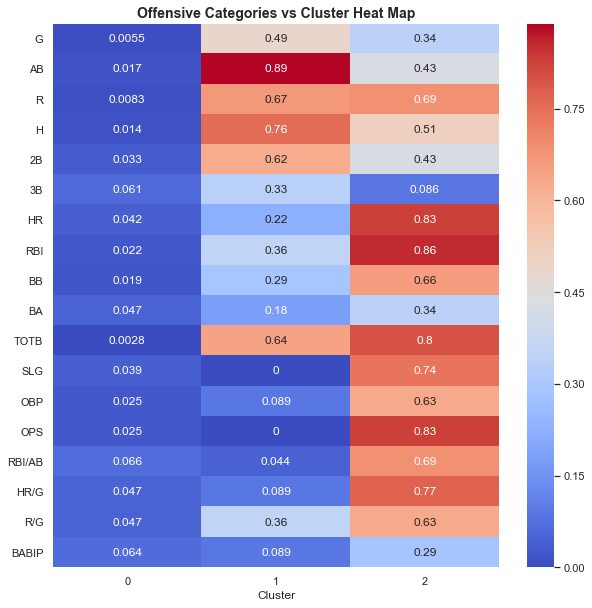

In [128]:
plt.figure(figsize = (10,10))
plt.title('Offensive Categories vs Cluster Heat Map', fontsize = 14, fontweight = "bold")
#sns.set(font_scale=1)  # crazy big
sns.heatmap(Top10Percentiles_Batting[(Top10Percentiles_Batting['yearID'] == 2015)
                        ].groupby(['Cluster']).mean(
        )[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'BB', 'BA', 'TOTB', 'SLG', 'OBP', 'OPS', 'RBI/AB', 'HR/G', 'R/G',
       'BABIP']].transpose(), cmap = 'coolwarm', annot=True, );

# Does salary line up with our findings?
Another quick way to evaluate the value of players is to see which players are getting paid the most. You would assume that the players who are getting paid the most are the best players. To double check that we are looking at the right subset of players, we can see how these clusters compare in average salary over time

In [129]:
# This will perge the Top 10 Percentiles data frame with the Salaries data. Similar to what we had to do with
# the batting information, I decided to take the max salary for each person for each year. 
# From there, I took the average salary for each cluster
mean_salaries = pd.merge(Top10Percentiles_Batting, Salaries[['yearID','playerID','salary']
                        ].groupby(['yearID','playerID'], as_index = False).max()).groupby(['Cluster','yearID']
                                                , as_index = False).mean()[['Cluster','yearID','salary']]

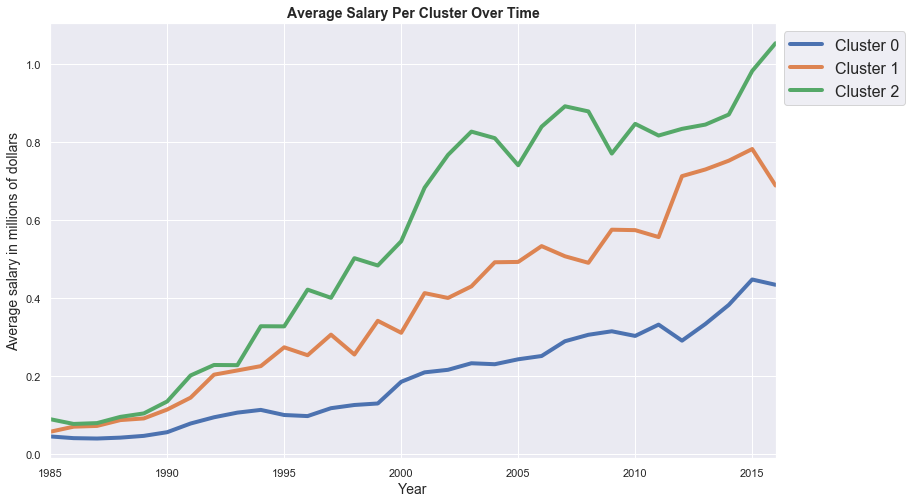

In [133]:
plt.figure(figsize = (13,8))

# For each cluster, plot the average salary over time
for cluster in [0,1,2]:
    df = mean_salaries[mean_salaries['Cluster'] == cluster][['yearID','salary']]
    df.set_index('yearID', inplace = True)

    (df['salary'] / 10000000).plot(label = 'Cluster ' +  str(cluster), linewidth = 4)
    
plt.legend(fontsize = 16,bbox_to_anchor=(1, 1))
plt.ylabel("Average salary in millions of dollars", fontsize = 14)
plt.xlabel("Year", fontsize = 14)
plt.title("Average Salary Per Cluster Over Time", fontsize = 14, fontweight = "bold");

Just like I anticipated, these trends have consistently shown since 1985 that Cluster 2 has been paid the most on average due to having the best players. It is also interesting to see the different times where clusters have come close to each other and which other times the clusters have had their biggest peaks (look at the early 2000's when the steriod era was at its peak. You needed players who could hit the ball a mile).

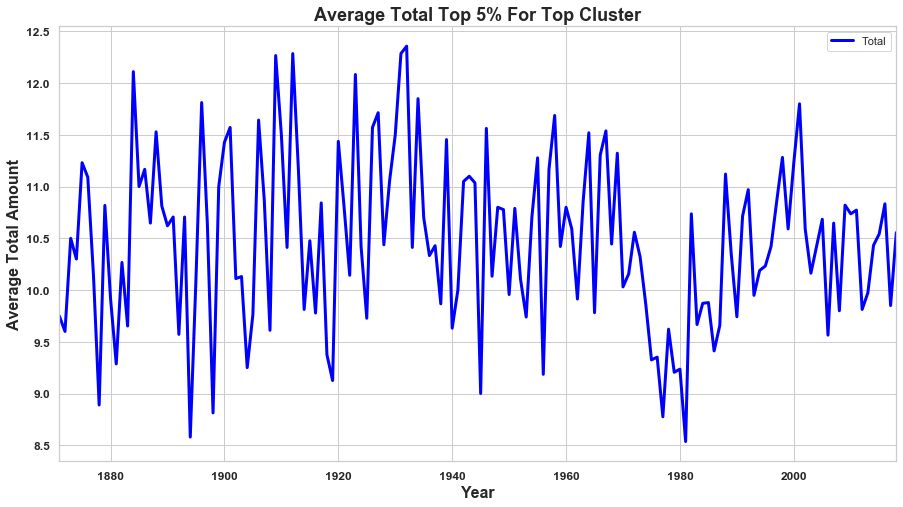

In [217]:
sns.set_style("whitegrid", {'axes.grid' : True})
Top10Percentiles_Batting[Top10Percentiles_Batting['Cluster'] == 2][
    ['nameFirst','nameLast','yearID','Total']].groupby(['yearID']).mean()[['Total']
    ].plot(figsize = (15,8), linewidth = 3,color='blue')
plt.ylabel('Average Total Amount',fontsize = 16, fontweight = 'bold')
plt.xlabel('Year',fontsize = 16, fontweight = 'bold')
plt.yticks(fontsize = 12, fontweight = 'bold')
plt.xticks(fontsize = 12, fontweight = 'bold')
plt.title('Average Total Top 5% For Top Cluster',fontsize = 18, fontweight = 'bold');

# Final Discussion

The main question that we were trying to answer was "Perform a player scoring to indicate the value of the players in the dataset". We were able to answer these questions by doing the following:

1. Normalize the data for each player each year to see what percentile they finished for that season
2. Use clustering methods to find groups of players that fit together, and which ones were considered the best for that season (which happened to be Cluster 2)
3. Show which offensive categories are most common in each cluster group of players, showing that players who are more advanced in the categories pertaining to power are considered to be the best hitters
4. Show that over time, that group of high power players on average are paid at a higher rate than other players. We should assume that people who have to pay these players understand which ones are the best in the league


# Why I chose clustering

The clustering algorithm was my choice in method because there is no correct "output" that we can compare against. Clustering is great to split objects into different groups, which is how I could separate the top players from the rest of the population. I also made some other modifications, like using flags of the top 10th percentile for each offensive category to better limit the top players.

# Limitations

The limitations of the clustering algorithm at this point is that it can only look back at the full year. When the new year starts, everyone will have 0's in each category, making it difficult to understand who truly the best players are until the end of the year. 

Another limitation with determining which players are the best only using offensive categories are outside influences. For example Paul Goldshmidt showed every indication that he should have been the MVP with the data that was used. However, he is a first basemen and doesn't bring much value to defense like a middle infielder our outfielder, which is probably why he got beat out by Bryce Harper. Another outside influncer could be the location of where the player plays his home games. Do players from Colorado have a higher likelihood of being in the top cluster because they play at hitter friendly fields? 

# Next Steps

Like I mentioned in the limitations section, doing more analysis on which players are in the top cluster could be rephrased to "should they belong to the top cluster?". By doing more analysis on players that have inflated offensive numbers because of their physical surroundings could be interesting to show how players would benefit / impede a players ability to be considered a top hitter. 

Another great analsis that could be done with the correct data could be a "real time" project to evaluate players throghout the season. This scenario could show what statistics a player would need X games into the season to be in the top cluster. Is a player on pace to be a top player this year?